In [1]:
import xarray as xr
import dask
from xmitgcm import open_mdsdataset
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.cm as pcm
import cartopy.crs as ccrs
import matplotlib.path as mpath
import matplotlib.ticker as mticker
import matplotlib.colors as col
import cmocean.cm as cm
from colorspace.colorlib import HCL
from colorspace import diverging_hcl, sequential_hcl
from matplotlib import rc, rcParams
# rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]
rcParams.update({"text.usetex": True})
rc('xtick', labelsize=15) 
rc('ytick', labelsize=15) 
rc('axes', labelsize=15)
import cmaps

In [3]:
# unfortunately this solution is only available in ascii or hdf5 format
# ascii seems easier to convert to netcdf so I'm going to go with that
rootdir          = '/export/data1/rmoorman/GRACE-GRACEFO/GSFC.glb.200204_202104_RL06v1.0_OBP-ICE6GD/'
mascon           = np.loadtxt(rootdir+'GSFC.glb.200204_202104_RL06v1.0_OBP-ICE6GD.txt',skiprows=11)
mascon_placement = np.loadtxt(rootdir+'Mascon_placement_file_gen6.txt', skiprows=14)
mascon_time      = np.loadtxt(rootdir+'Time_file_200204_202104.txt', skiprows=14)
mascon_uncert_leakage_2sig  = np.loadtxt(rootdir+'Uncertainty_leakage_2sigma_200204_202104.txt', skiprows=8)
mascon_uncert_leakage_trend = np.loadtxt(rootdir+'Uncertainty_leakage_trend_200204_202104.txt', skiprows=8)
mascon_uncert_noise_2sig    = np.loadtxt(rootdir+'Uncertainty_noise_2sigma_200204_202104.txt', skiprows=9)

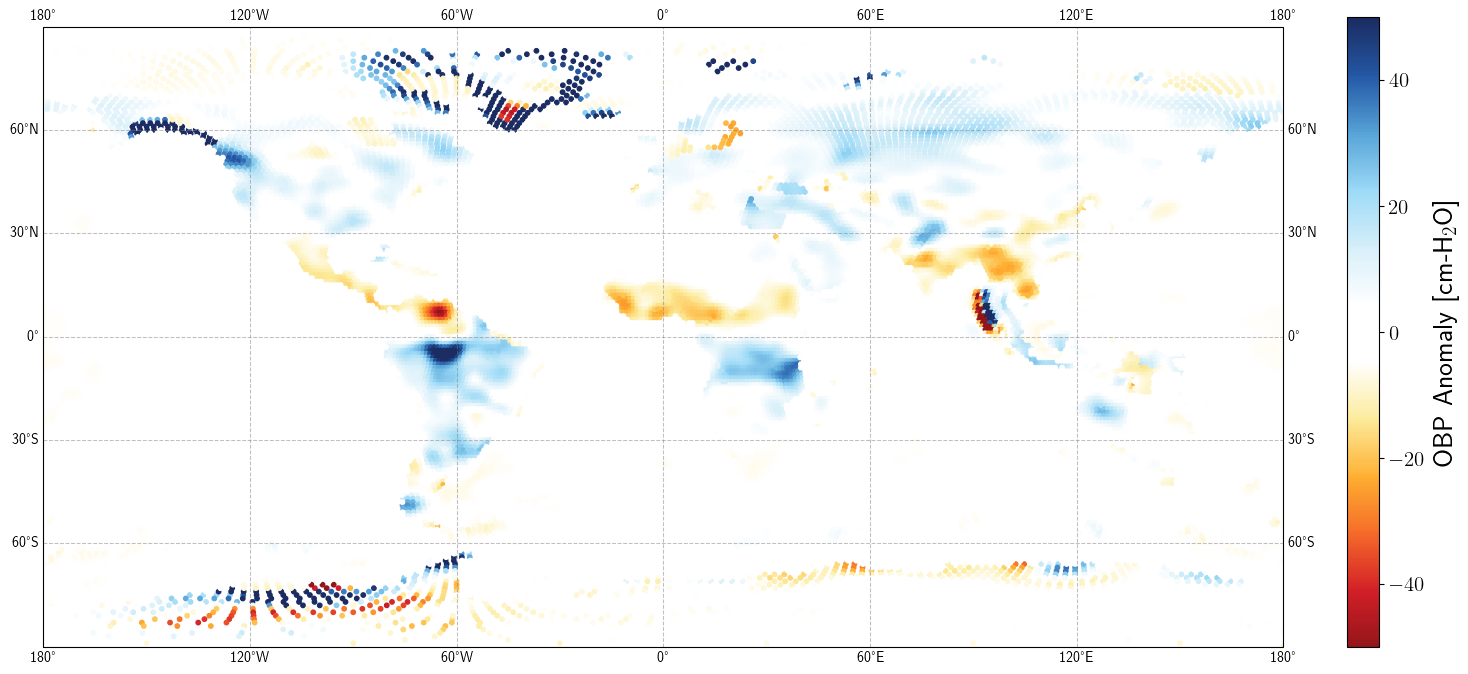

In [4]:
fig = plt.figure(figsize=(16,9))
ax = plt.subplot(projection=ccrs.PlateCarree())
ax.set_global();ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=0.75, color='gray', alpha=0.5, linestyle='--')
cs=ax.scatter(mascon_placement[:,1], mascon_placement[:,0], c=mascon[:,0], cmap=cmaps.BlueWhiteOrangeRed_r, s=10,vmin=-50, vmax=50,transform=ccrs.PlateCarree())
cax = fig.add_axes([0.94, 0.15, 0.02, 0.7])
cbar=plt.colorbar(cs,cax = cax,orientation='vertical')
cbar.set_label('OBP Anomaly [cm-H$_2$O]', fontsize = 20)
plt.show()


Made an attempt to try and plot as pcolormesh grids without intepolating but populating the nan sections of the grid with the last value...but it doesn't really work, so interpolation will be the go I think.

In [5]:
mascon_longitude = xr.DataArray(mascon_placement[:,1], coords=[np.arange(41168)], dims=['mascon_index'])
mascon_latitude = xr.DataArray(mascon_placement[:,0], coords=[np.arange(41168)], dims=['mascon_index'])
mascon_latitude_width = xr.DataArray(mascon_placement[:,2], coords=[np.arange(41168)], dims=['mascon_index'])
mascon_longitude_width = xr.DataArray(mascon_placement[:,3], coords=[np.arange(41168)], dims=['mascon_index'])
mascon_area_km2 = xr.DataArray(mascon_placement[:,5], coords=[np.arange(41168)], dims=['mascon_index'])
mascon_type = xr.DataArray(mascon_placement[:,7], coords=[np.arange(41168)], dims=['mascon_index'])
mascon_longitude = mascon_longitude.assign_coords(mascon_longitude=mascon_longitude,mascon_latitude=mascon_latitude,mascon_latitude_width=mascon_latitude_width,mascon_longitude_width=mascon_longitude_width,mascon_area_km2=mascon_area_km2,mascon_type=mascon_type)


In [6]:
gridded_index = xr.DataArray(np.zeros((360,181)), coords=[np.arange(0.5,360),np.arange(-90,91)], dims=['lon_DUMMY','latC'])
gridded_geolonC = xr.zeros_like(gridded_index)
gridded_geolatC = xr.zeros_like(gridded_index)
gridded_geolatG = xr.zeros_like(gridded_index)
gridded_geolonG = xr.zeros_like(gridded_index)
gridded_type = xr.zeros_like(gridded_index)
gridded_lat_width = xr.zeros_like(gridded_index)
gridded_lon_width = xr.zeros_like(gridded_index)
gridded_area = xr.zeros_like(gridded_index)
gridded_index[::]=np.nan
gridded_geolonC[::]=np.nan
gridded_geolonG[::]=np.nan
gridded_type[::]=np.nan
gridded_lat_width[::]=np.nan
gridded_lon_width[::]=np.nan
gridded_area[::]=np.nan

In [7]:
latCgrid,_ = np.meshgrid(np.arange(-90,91),np.arange(0.5,360))

In [8]:
gridded_geolatC[::] = latCgrid
gridded_geolatG[::] = latCgrid-0.5

In [9]:
gridded_index.attrs['description']="mascon index in original ASCII file"
gridded_geolonC.attrs['description']="longitude at the cell center"
gridded_geolatC.attrs['description']="latitude at the cell center"
gridded_geolatG.attrs['description']="latitude at the cell southwest corner (for pcolormesh plotting)"
gridded_geolonG.attrs['description']="longitude at the cell southwest corner (for pcolormesh plotting)"
gridded_type.attrs['description']="cell type (GIS=1, AIS=3, Ice shelf=4, GOA=5, Land=80, Ocean=90) "
gridded_lat_width.attrs['description'] = "latitude cell width"
gridded_lon_width.attrs['description'] = "longitude cell width"
gridded_area.attrs['description'] = "cell area"

gridded_index.attrs['units'] = "none"
gridded_geolonC.attrs['units'] = "degrees"
gridded_geolatC.attrs['units'] = "degrees"
gridded_geolonG.attrs['units'] = "degrees"
gridded_geolatG.attrs['units'] = "degrees"
gridded_type.attrs['units'] = "none"
gridded_lat_width.attrs['units'] = "degrees"
gridded_lon_width.attrs['units'] = "degrees"
gridded_area.attrs['units'] = "km2"

In [10]:
unique_lats = np.arange(-90,91)
for i in range(181):
    longitudeC = mascon_longitude.where(mascon_longitude.mascon_latitude==unique_lats[i],drop=True)
    longitudeC = longitudeC.sortby('mascon_longitude')
    length=len(longitudeC.values)
    if len(np.diff(longitudeC))>0:
        longitudeG = longitudeC - np.diff(longitudeC)[0]/2
    else:
        longitudeG=longitudeC-180
    longitudeC_filled = np.concatenate((longitudeC.values, np.linspace(0,0.1,360-length)+longitudeC.values[-1]))
    longitudeG_filled = np.concatenate((longitudeG.values, np.linspace(0,0.1,360-length)+longitudeG.values[-1]))
    index_filled = np.concatenate((longitudeC.mascon_index, np.zeros((360-length))+longitudeC.mascon_index.values[-1]))
    type_filled = np.concatenate((longitudeC.mascon_type, np.zeros((360-length))+longitudeC.mascon_type.values[-1]))
#     indices = longitudeC.mascon_index
    gridded_index[:,i]     = index_filled
    gridded_geolonC[:,i]   = longitudeC_filled
    gridded_geolonG[:,i]   = longitudeG_filled
    gridded_type[:,i]      = type_filled
#     gridded_lat_width[:len(indices),i] = longitudeC.mascon_latitude_width.values
#     gridded_lon_width[:len(indices),i] = longitudeC.mascon_longitude_width.values
#     gridded_area[:len(indices),i]      = longitudeC.mascon_area_km2.values

In [11]:
time = np.zeros((196),dtype='datetime64[D]')
for day in range(196):
    time[day] = np.datetime64(int(mascon_time[day,0])-1970, 'Y')+np.timedelta64(int(mascon_time[day,1]), 'D')

In [12]:
gridded_GSFC_mascons = xr.DataArray(np.zeros((360,181,196)), coords=[np.arange(0.5,360),np.arange(-90,91),time], dims=['lon_DUMMY','latC','time'])
gridded_GSFC_mascons[::] = np.nan

In [13]:
for m in range(41168):
    i,j = np.where(gridded_index==m)
    if len(i)>0:
        for k in range(len(i)):
            gridded_GSFC_mascons[i[k],j[k],:] = mascon[m,:].flatten()
    else:
        gridded_GSFC_mascons[i,j,:] = mascon[m,:].flatten()

In [14]:
gridded_GSFC_mascons.time.attrs['description'] = "middle day of solution period"
gridded_GSFC_mascons.lon_DUMMY.attrs['description'] = "dummy longitude dimension (DO NOT USE - USE geolonC or geolonG)"
gridded_GSFC_mascons.latC.attrs['description'] = "latitude at cell center"

gridded_GSFC_mascons.attrs['title'] = "NASA GSFC mascons solution file: GSFC.glb.200204_202104_RL06v1.0_OBP-ICE6GD"
gridded_GSFC_mascons.attrs['citation'] = "https://doi.org/10.1007/s00190-019-01252-y"
gridded_GSFC_mascons.attrs['contact'] = "Bryant.D.Loomis@nasa.gov"
gridded_GSFC_mascons.attrs['units'] = "cm equivalent water height / ocean bottom pressure"
gridded_GSFC_mascons.attrs['geocenter_correction'] = "JPL TN-13"
gridded_GSFC_mascons.attrs['c20_c30_correction'] = "TN-14"
gridded_GSFC_mascons.attrs['gia_correction'] = "ICE-6G_D"


In [15]:
days_in_solution = xr.DataArray(mascon_time[:,6],coords=[time], dims=['time'])

In [16]:
gridded_GSFC_mascons = gridded_GSFC_mascons.assign_coords(geolatC =gridded_geolatC, geolatG =gridded_geolatG,  geolonC=gridded_geolonC,mascon_index=gridded_index,geolonG=gridded_geolonG,cell_type=gridded_type,lat_width=gridded_lat_width,lon_width=gridded_lon_width,cell_area=gridded_area,days_in_solution=days_in_solution)


In [17]:
plot = gridded_GSFC_mascons.isel(time=0)

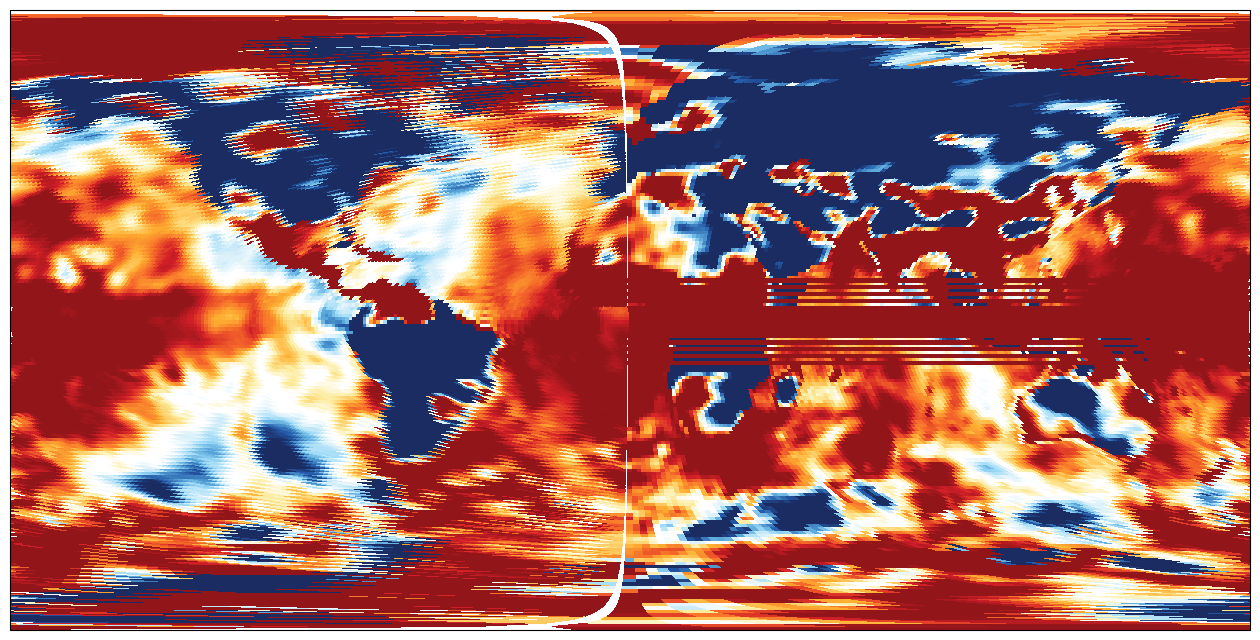

In [18]:
fig = plt.figure(figsize=(16,9))
ax = plt.subplot(projection=ccrs.PlateCarree())
# ax.set_global();ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=0.75, color='gray', alpha=0.5, linestyle='--')
ax.pcolormesh(plot.geolonG, plot.geolatG, plot, cmap=cmaps.BlueWhiteOrangeRed_r,vmin=-3,vmax=3, transform=ccrs.PlateCarree())
# ax.pcolormesh(plot.latC, plot.lon_DUMMY, plot, cmap=cmaps.BlueWhiteOrangeRed_r,transform=ccrs.PlateCarree())
plt.show()


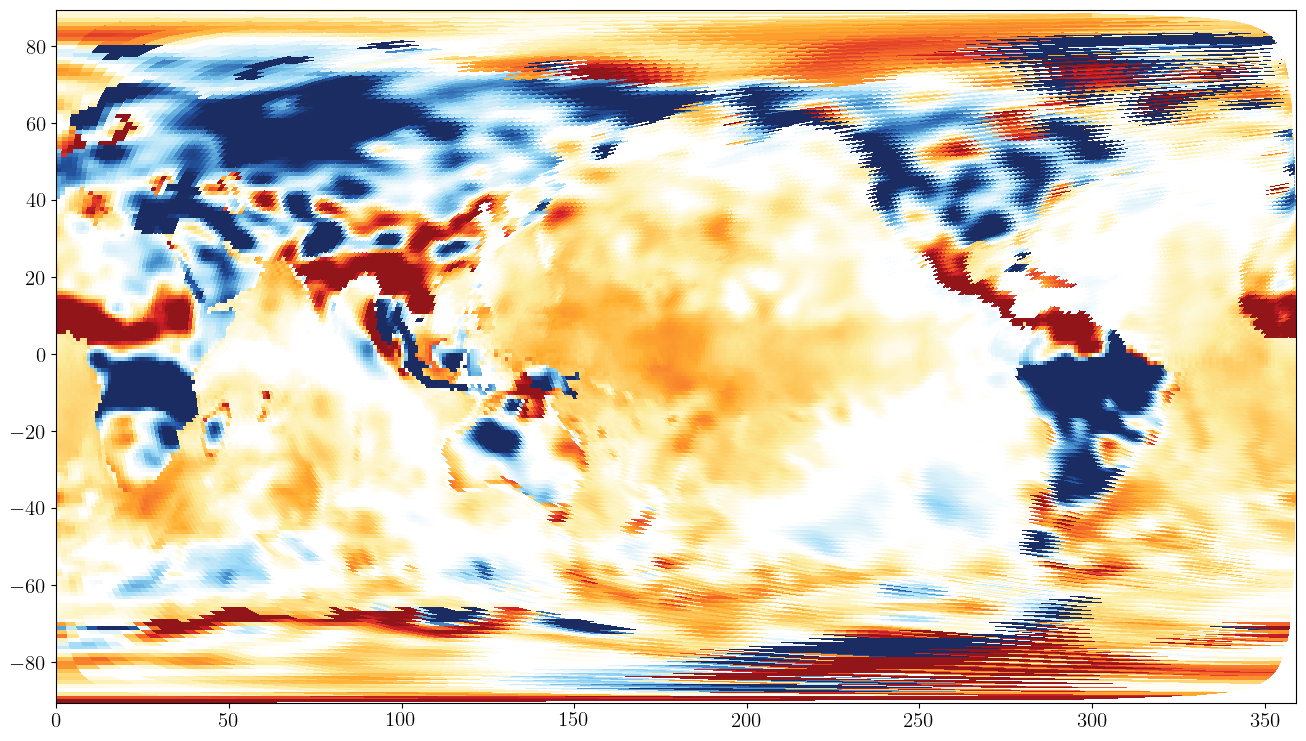

In [19]:
fig = plt.figure(figsize=(16,9))
ax = plt.subplot()
# ax.set_global();ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=0.75, color='gray', alpha=0.5, linestyle='--')
ax.pcolormesh(plot.geolonG, plot.geolatG, plot, cmap=cmaps.BlueWhiteOrangeRed_r,vmin=-10,vmax=10)#, transform=ccrs.PlateCarree())
# ax.pcolormesh(plot.latC, plot.lon_DUMMY, plot, cmap=cmaps.BlueWhiteOrangeRed_r,transform=ccrs.PlateCarree())
plt.show()


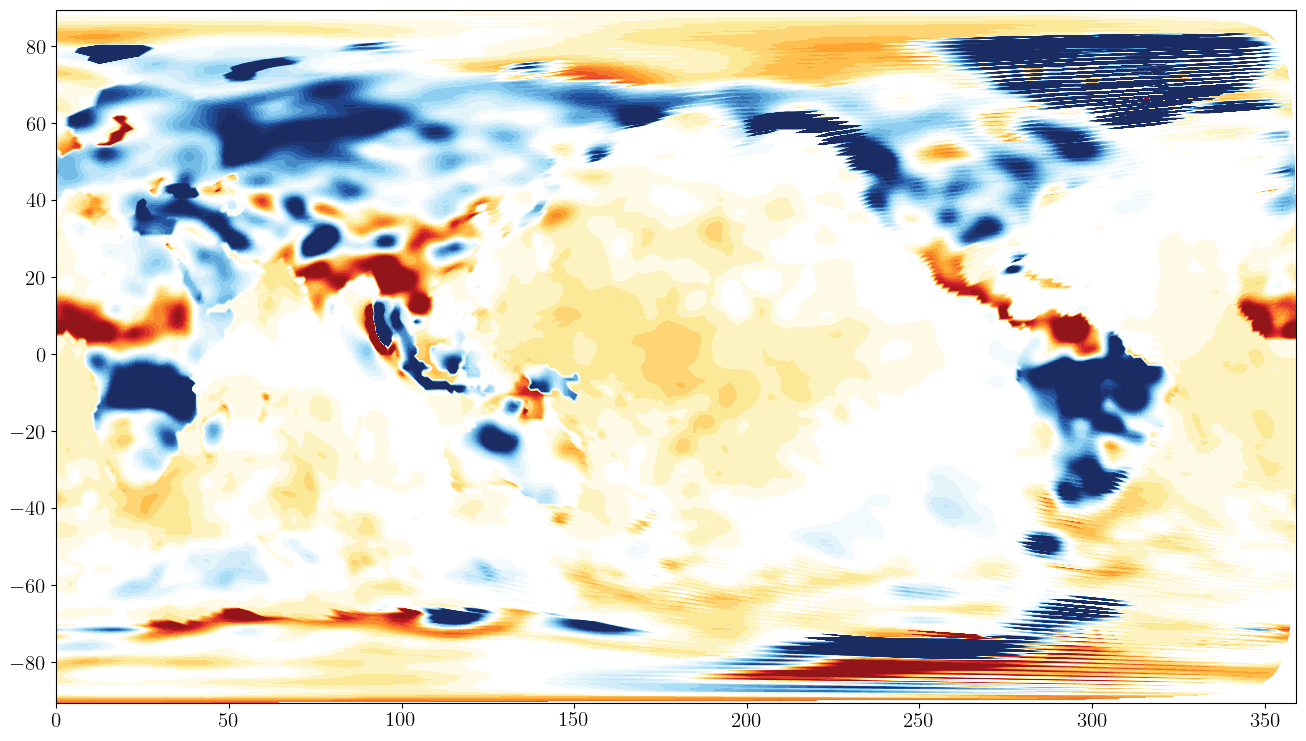

In [20]:
fig = plt.figure(figsize=(16,9))
ax = plt.subplot()
# ax.set_global();ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=0.75, color='gray', alpha=0.5, linestyle='--')
ax.contourf(plot.geolonG, plot.geolatG, plot, cmap=cmaps.BlueWhiteOrangeRed_r,levels=np.linspace(-15,15,30), extend='both')#, transform=ccrs.PlateCarree())
# ax.pcolormesh(plot.latC, plot.lon_DUMMY, plot, cmap=cmaps.BlueWhiteOrangeRed_r,transform=ccrs.PlateCarree())
plt.show()


Let's try interpolation onto an even grid instead, but not now, it doesn't seem super necessary so aybe it will be possible just to work with the provided structure.

In [21]:
# unfortunately this solution is only available in ascii or hdf5 format
# ascii seems easier to convert to netcdf so I'm going to go with that
rootdir          = '/export/data1/rmoorman/GRACE-GRACEFO/GSFC.glb.200204_202104_RL06v1.0_OBP-ICE6GD/'
mascon           = np.loadtxt(rootdir+'GSFC.glb.200204_202104_RL06v1.0_OBP-ICE6GD.txt',skiprows=11)
mascon_placement = np.loadtxt(rootdir+'Mascon_placement_file_gen6.txt', skiprows=14)
mascon_time      = np.loadtxt(rootdir+'Time_file_200204_202104.txt', skiprows=14)
mascon_uncert_leakage_2sig  = np.loadtxt(rootdir+'Uncertainty_leakage_2sigma_200204_202104.txt', skiprows=8)
mascon_uncert_leakage_trend = np.loadtxt(rootdir+'Uncertainty_leakage_trend_200204_202104.txt', skiprows=8)
mascon_uncert_noise_2sig    = np.loadtxt(rootdir+'Uncertainty_noise_2sigma_200204_202104.txt', skiprows=9)

In [22]:
mascons   = xr.DataArray(mascon, coords=[np.arange(41168), time], dims=['index', 'time'])
lonC = xr.DataArray(mascon_placement[:,1], coords=[np.arange(41168)], dims=['index'])
latC = xr.DataArray(mascon_placement[:,0], coords=[np.arange(41168)], dims=['index'])
lat_width = xr.DataArray(mascon_placement[:,2], coords=[np.arange(41168)], dims=['index'])
lon_width = xr.DataArray(mascon_placement[:,3], coords=[np.arange(41168)], dims=['index'])
area = xr.DataArray(mascon_placement[:,5], coords=[np.arange(41168)], dims=['index'])
cell_type = xr.DataArray(mascon_placement[:,6], coords=[np.arange(41168)], dims=['index'])
mascons = mascons.assign_coords(lonC=lonC,latC=latC,lat_width=lat_width,lon_width=lon_width,area=area,cell_type=cell_type)

In [23]:
ocean_mascons = mascons.where(mascons.cell_type==90, drop=True)

In [24]:
ocean_mascons

<xarray.DataArray (index: 28140, time: 196)>
array([[-1.7695, -1.173 ,  2.5952, ...,  3.0406,  2.4389,  0.1126],
       [-1.4984, -1.399 ,  2.9153, ...,  4.2616,  2.9051,  1.2743],
       [-1.1658, -1.2058,  3.0235, ...,  3.378 ,  1.7532,  0.0754],
       ...,
       [-8.874 ,  0.3772,  0.0887, ...,  7.945 , 11.0399,  9.3531],
       [-8.0956,  3.7868, -0.2826, ...,  7.4182,  5.4923,  4.425 ],
       [-8.6313,  5.5089, -1.5552, ...,  7.5005,  0.0357, -0.856 ]])
Coordinates:
  * index      (index) int64 13028 13029 13030 13031 ... 41164 41165 41166 41167
  * time       (time) datetime64[ns] 2002-04-19 2002-05-11 ... 2021-04-17
    lonC       (index) float64 180.0 30.0 90.0 150.0 ... 276.3 278.1 279.9 281.7
    latC       (index) float64 90.0 89.0 89.0 89.0 89.0 ... 56.0 56.0 56.0 56.0
    lat_width  (index) float64 0.5 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
    lon_width  (index) float64 360.0 60.0 60.0 60.0 60.0 ... 1.8 1.8 1.8 1.8 1.8
    area       (index) float64 9.667e+03 1.289e+04 ... 1.242e+04 1.242e+04
    cell_type  (index) float64 90.0 90.0 90.0 90.0 90.0 ... 90.0 90.0 90.0 90.0

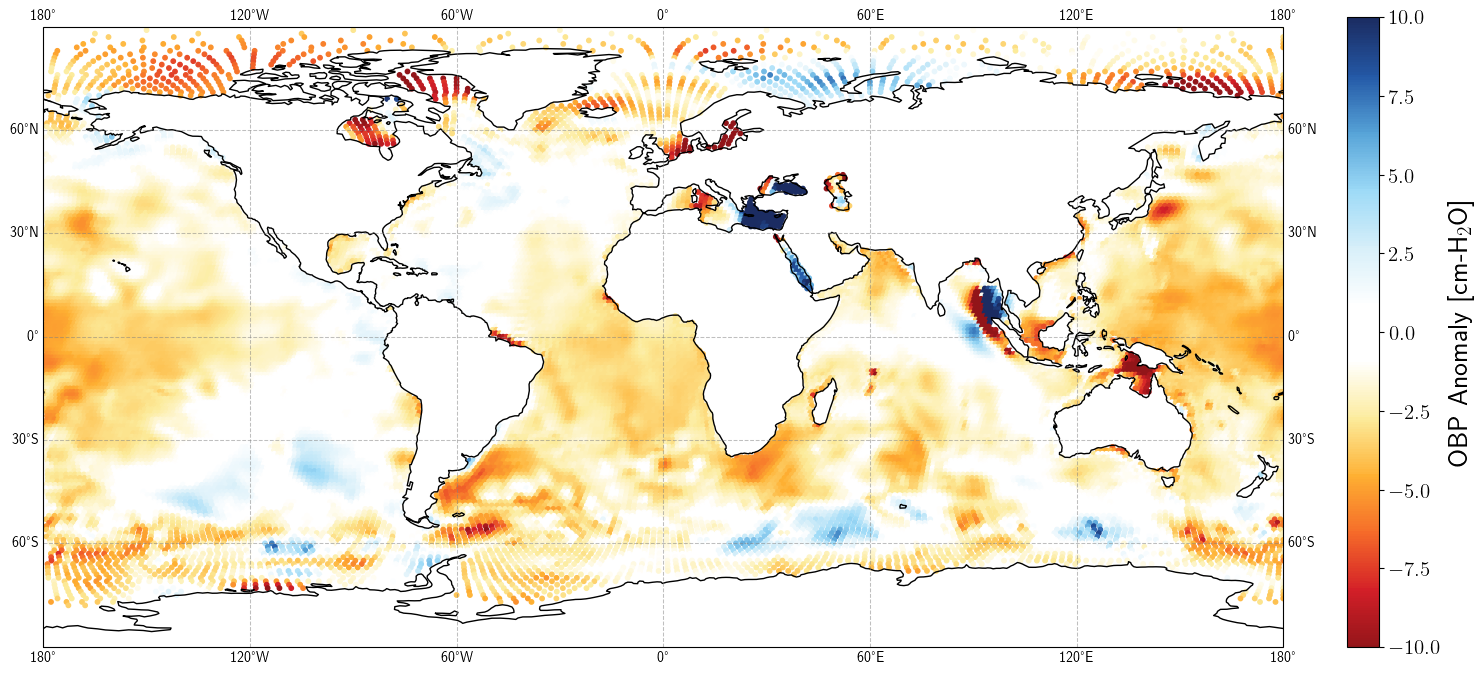

In [25]:
fig = plt.figure(figsize=(16,9))
ax = plt.subplot(projection=ccrs.PlateCarree())
ax.set_global();ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=0.75, color='gray', alpha=0.5, linestyle='--');ax.coastlines()
cs=ax.scatter(ocean_mascons.lonC, ocean_mascons.latC, c=ocean_mascons.isel(time=0), cmap=cmaps.BlueWhiteOrangeRed_r, s=10,vmin=-10, vmax=10,transform=ccrs.PlateCarree())
cax = fig.add_axes([0.94, 0.15, 0.02, 0.7])
cbar=plt.colorbar(cs,cax = cax,orientation='vertical')
cbar.set_label('OBP Anomaly [cm-H$_2$O]', fontsize = 20)
plt.show()


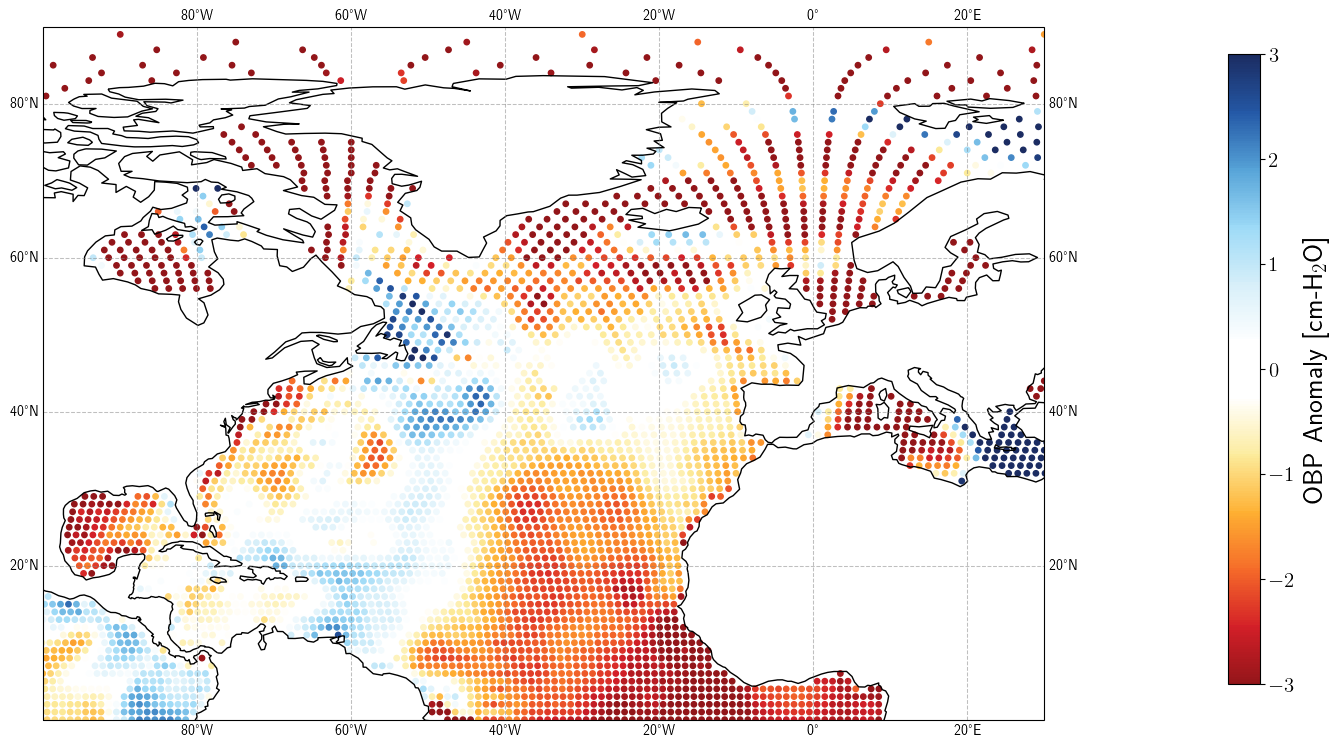

In [26]:
fig = plt.figure(figsize=(16,9))
ax = plt.subplot(projection=ccrs.PlateCarree())
ax.set_global();ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=0.75, color='gray', alpha=0.5, linestyle='--');ax.coastlines()
cs=ax.scatter(ocean_mascons.lonC, ocean_mascons.latC, c=ocean_mascons.isel(time=0), cmap=cmaps.BlueWhiteOrangeRed_r, s=15,vmin=-3, vmax=3,transform=ccrs.PlateCarree())
cax = fig.add_axes([0.94, 0.15, 0.02, 0.7])
cbar=plt.colorbar(cs,cax = cax,orientation='vertical')
cbar.set_label('OBP Anomaly [cm-H$_2$O]', fontsize = 20)
ax.set_extent([-100, 30, 0, 90], crs=ccrs.PlateCarree())
plt.show()
